In [1]:
import os.path
import subprocess
import shlex
import numpy as np
import matplotlib.pyplot as plt

### 1. Load File and Initialize

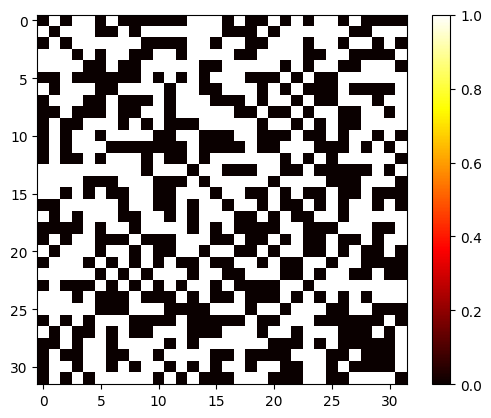

In [2]:
# Define the problem
numSpin = 32
adjMatrix = np.zeros((numSpin, numSpin))
for i in range(numSpin):
    for j in range(i+1, numSpin):
        random_value = np.random.choice([0, 1],p=[0.5,0.5])
        adjMatrix[i][j] = random_value
        adjMatrix[j][i] = random_value

plt.imshow(adjMatrix, cmap='hot', interpolation='nearest')
plt.colorbar()

### 2. Write Netlist

In [3]:
fileHeader = './netlist/netlistHeader.scs'
fileName = 'maxcutproblem'
fileNetlist = f'./netlist/{fileName}.scs'

stopTime = 500e-9
Ron = 1e4
Roff = 1e6
initAnnG = abs(np.linalg.eigvals(adjMatrix).min()) # calculate a proper initial annealing conductance

with open(fileHeader, 'r') as f1, open(fileNetlist, 'w') as f2:
    # import subcircuit and header
    f2.write(f1.read())
    f2.write('\n')
    # import netlist of array
    for ii in range(adjMatrix.shape[0]):
        for jj in range(adjMatrix.shape[1]):
            if adjMatrix[ii,jj] != 0:
                f2.write(f'R_{ii+1}_{jj+1} (Row{ii+1} Col{jj+1}) resistor r={Ron}\n')
            else:
                f2.write(f'R_{ii+1}_{jj+1} (Row{ii+1} Col{jj+1}) resistor r={Roff}\n')
    # add annealing module to netlist
    for ii in range(adjMatrix.shape[0]):
        f2.write(f'Rf_{ii+1} Row{ii+1} Col{ii+1} resistor r={Ron}/({initAnnG}-($time)*({initAnnG}/{stopTime}))\n')
    # add spin amplifiers
    for ii in range(adjMatrix.shape[0]):
        f2.write(f'OA_{ii+1} (0 Col{ii+1} Row{ii+1}) opamp Voh=0.2 Vol=-0.2 Gain=1000 GBW=500M Rdc=30 Rac=10\n')
    f2.write('\n')
    # add simulation configuration
    f2.write(f'tran tran stop={stopTime} errpreset=liberal \\\n')
    f2.write('  annotate=status maxiters=5 \\\n')
    f2.write('  noisefmax=1e10 mc_auto_noiseseed=yes noisescale=1 \n')
    f2.write('save ')
    for ii in range(numSpin):
        f2.write(f'Row{ii+1} ')


### 3. Run Simulation

In [4]:
runfile = fileNetlist

spectre_args = ["spectre -64",
        runfile,
        "+escchars",
        "+multithread",
        "++aps=liberal",
        "=log ./result/" + fileName + "/psf/spectre.out",
        "-format psfascii",
        "-raw ./result/" + fileName + "/psf"]
run_string = ""
for i in spectre_args:
    run_string = run_string + i + " "
    
run_command = shlex.split(run_string)
print("Running simulation...")
subprocess.call(run_command) 
print("Done.")

Running simulation...
Done.


### 4. Collect and Analyze Results

In [5]:
fileResult = f'./result/{fileName}/psf/tran.tran.tran'
with open(fileResult, 'r') as file:
    lines = file.readlines()

time = []
value = []
i = 0
while i < len(lines):
    if lines[i].split()[0] == 'VALUE':
        del lines[0:i]
        break
    i = i+1

i = 0
while i < len(lines):
    if lines[i].strip().startswith('"time"'):
        time.append(float(lines[i].split()[1]))
        for j in range(numSpin):
            value.append(float(lines[i+j+1].split()[2]))

    i += 1

time = np.array(time)
value = np.array(value).reshape(-1, numSpin)

### 5. Plot Results

Text(0, 0.5, 'Voltage (V)')

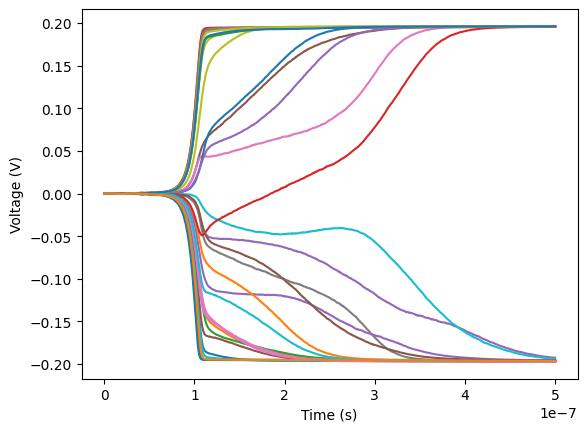

In [6]:
plt.plot(time,value)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

Text(0, 0.5, 'Ising Energy (a.u.)')

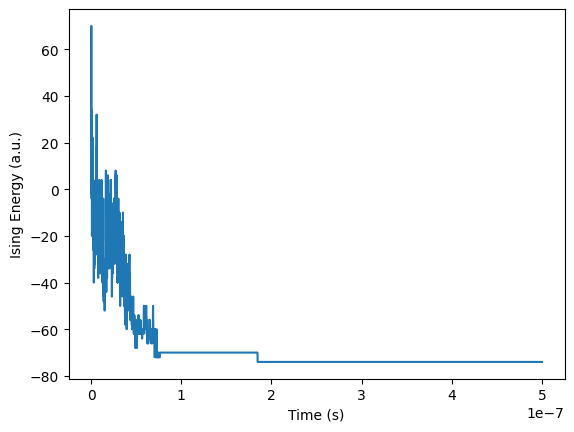

In [7]:
spinVector = np.sign(value)
energy = np.zeros(spinVector.shape[0])
for i in range(spinVector.shape[0]):
    energy[i] = -0.5*np.dot(spinVector[i,:],np.dot(-adjMatrix,spinVector[i,:]))
plt.plot(time,energy)
plt.xlabel('Time (s)')
plt.ylabel('Ising Energy (a.u.)') 